# Distracted Driver Detection – Data Cleaning and Preparation

This notebook focuses on preparing the dataset for our CNN-based distracted driver classification pipeline. We'll go through the process of:

1. Extracting and flattening the raw dataset
2. Cleaning and restructuring image directories
3. Parsing the metadata CSV
4. Mapping and filtering class labels
5. Removing unused classes
6. Saving the cleaned image metadata for further modeling

This preparation sets the foundation for model training in our baseline and custom CNN notebooks.


In [ ]:
#Importing Necessary libraries
import zipfile
import os
import shutil
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
from sklearn.model_selection import train_test_split



## 1. Extract Raw Dataset from ZIP

We extract the original Kaggle ZIP file containing driver behavior images. The data contains training and testing image folders, structured into class-labeled subdirectories (c0 to c9).


In [ ]:
#code to extract zip file in drive
# Instructions : ONLY RUN ONCE with the dataset in the main folder path
zip_path="../state-farm-distracted-driver-detection.zip"
extracted_path="../raw_data"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

print("Extracted files:", os.listdir(extracted_path))

Extracted files: ['driver_imgs_list.csv', 'imgs', 'sample_submission.csv']


## 2. Flatten and Organize Raw Images

The original dataset has images grouped by class (`c0` to `c9`) under the `train/` directory.

We flatten this structure and copy all relevant class images (`c0`, `c1`, `c2`, `c3`, `c4`, `c6`) into a single directory called `filtered_dataset/`, preserving the original image names. We avoid duplicates and do not rename the images.


In [ ]:


# Source and destination directories of raw images
source_root = "../raw_data/imgs"
dest_root = "../full_dataset"

os.makedirs(dest_root, exist_ok=True)

# COllecting all files to track with a progress bar using tqdm
all_files = []
for subfolder in ['train', 'test']:
    full_path = os.path.join(source_root, subfolder)
    for root, dirs, files in os.walk(full_path):
        for file in files:
            src_file = os.path.join(root, file)
            dest_file = os.path.join(dest_root, file)
            all_files.append((src_file, dest_file))

# Copying required images to the folder titled full_dataset
print(f"Copying {len(all_files)} images to 'full_dataset'...")
for src_file, dest_file in tqdm(all_files, desc="Copying files"):
    if not os.path.exists(dest_file):
        shutil.copy2(src_file, dest_file)

print("Done copying without duplicates or renaming.")


Copying 102150 images to 'full_dataset'...


Copying files:   0%|          | 0/102150 [00:00<?, ?it/s]

Done copying without duplicates or renaming.


## 3. Load and Clean Metadata CSV

We load the `driver_imgs_list.csv`, which contains:
- `subject` (driver ID)
- `classname` (original class label like `c0`, `c1`, etc.)
- `img` (image file name)

We rename the columns and filter the rows to include only the selected class folders we kept during image copying.


In [ ]:


# Path for CSV file that contains metadata and Image Directory
csv_file = "../raw_data/driver_imgs_list.csv"
images_dir = "../full_dataset"



df = pd.read_csv(csv_file)
df.rename(columns={ #renaming columns to make it more understandable
    "subject": "driver_id",
    "classname": "class_id",
    "img": "img_id"
}, inplace=True)

#  label mapping for required classes based on how we want the dataset to be stored
class_map = {
    "c0": "safe_driving",
    "c1": "using_phone",
    "c2": "using_phone",
    "c3": "using_phone",
    "c4": "using_phone",
    "c6": "drinking"
}

# Filtering relevant classes that we require using the map we created
df_filtered = df[df["class_id"].isin(class_map.keys())].copy()

# Applying mapping to class_id to reflect the changes
df_filtered["class_id"] = df_filtered["class_id"].map(class_map)

# Final class distribution check to see the class distribution
class_counts = df_filtered['class_id'].value_counts()
print(class_counts)


class_id
using_phone     9256
safe_driving    2489
drinking        2325
Name: count, dtype: int64


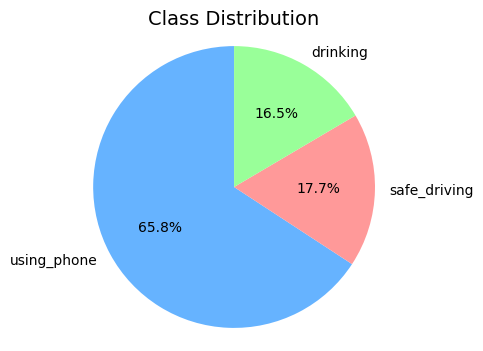

In [ ]:


# Plotting class distribution pie chart
plt.figure(figsize=(4, 4))
plt.pie(
    class_counts, 
    labels=class_counts.index, 
    autopct='%1.1f%%', 
    startangle=90,
    colors=['#66b3ff', '#ff9999', '#99ff99'] 
)
plt.title("Class Distribution", fontsize=14)
plt.axis('equal') 
plt.show()


### Class Distribution and Imbalance


This shows a clear class imbalance, with `using_phone` being significantly overrepresented compared to `safe_driving` and `drinking`. Such imbalance can cause the model to become biased toward the majority class, leading to poor generalization and unfair predictions.

Without addressing this imbalance, the model could achieve high accuracy by simply predicting the dominant class (`using_phone`) most of the time, while failing to correctly classify rare but important behaviors like `drinking`.

In our training phase (in the next notebook), we will handle this issue by applying **class weighting** during model training. This means the loss function will penalize mistakes on underrepresented classes more heavily, encouraging the model to pay more attention to them.

Additionally, we may use **targeted data augmentation** to artificially increase the diversity of minority classes during training.


## 4. Remap Classes to Logical Categories

We remap the original class IDs into simplified, semantically meaningful categories:
- `c0` → `safe_driving`
- `c1`, `c2`, `c3`, `c4` → `using_phone`
- `c6` → `drinking`

Classes `c5`, `c7`, `c8`, and `c9` are excluded from this project.


In [ ]:


# Paths for the directiories that contain entire dataset,the filtered dataset and the csv path which will contain our subset dataset metadata
images_dir = "../full_dataset"
filtered_dir = "../filtered_dataset"
output_csv_path = "../image_data.csv"

os.makedirs(filtered_dir, exist_ok=True)

# ensuring only files that exist in our subset are present in the metadata file
available_images = set(os.listdir(images_dir))
df_filtered = df_filtered[df_filtered["img_id"].isin(available_images)].copy()

# Copying images listed in df_filtered to filtered_dataset
print(f"Copying {len(df_filtered)} images to 'filtered_dataset'...")
for img_id in tqdm(df_filtered["img_id"], desc="Copying images"):
    src = os.path.join(images_dir, img_id)
    dst = os.path.join(filtered_dir, img_id)
    if not os.path.exists(dst):  # avoid re-copying
        shutil.copy2(src, dst)

# Saving filtered DataFrame as CSV
df_filtered.to_csv(output_csv_path, index=False)
print("Image copy and CSV export complete.")


Copying 14070 images to 'filtered_dataset'...


Copying images:   0%|          | 0/14070 [00:00<?, ?it/s]

Image copy and CSV export complete.


## 5. Remove Missing or Unused Files

We:
- Check if each `img_id` in the CSV exists in the flattened folder
- Drop rows where the image is missing
- Keep only the final cleaned set of rows



Sample images for class using_phone:


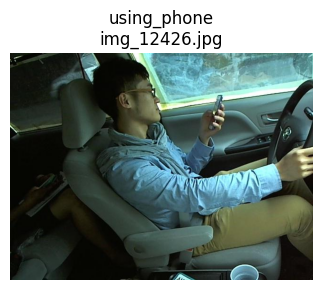


Sample images for class safe_driving:


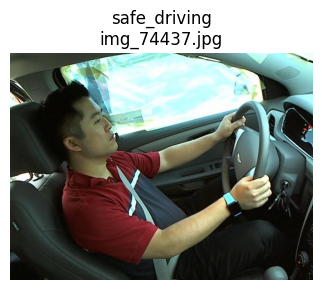


Sample images for class drinking:


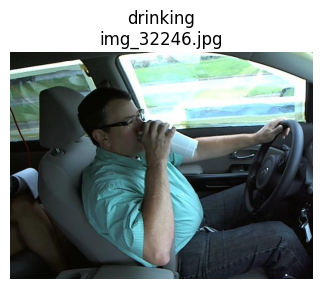

In [ ]:


# Path to the filtered dataset folder
image_dir = "../filtered_dataset"


# Function to randomly print samples from each class with the dataframe as a parameter,class_label and n= number of images
def plot_samples(df, class_label, n=3):
    samples = df[df["class_id"] == class_label].sample(n * 2, random_state=42)
    count = 0

    plt.figure(figsize=(4, 3))
    for img_id in samples["img_id"]:
        img_path = os.path.join(image_dir, img_id)

        if not os.path.exists(img_path):
            print(f"Skipping missing image: {img_id}")
            continue

        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to load: {img_path}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n, count + 1)
        plt.imshow(img)
        plt.title(f"{class_label}\n{img_id}")
        plt.axis('off')
        count += 1

        if count == n:
            break

    if count == 0:
        print(f"No valid images found for class {class_label}")
    plt.tight_layout()
    plt.show()

# Plotting samples for each class
for cls in ["using_phone", "safe_driving", "drinking"]:
    print(f"\nSample images for class {cls}:")
    plot_samples(df_filtered, cls, n=1)



### Visual Inspection of Sample Images per Class

The following preview shows sample images from each of the three target classes in the cleaned dataset:

---

#### Class: `using_phone`
- Images show drivers engaging with mobile phones in different ways:
  - Holding the phone to the ear (calls)
  - Holding the phone with one or both hands (texting, browsing)
- This class exhibits clear signs of hand-based and visual distraction
- Variation in lighting, clothing, and seating posture adds useful diversity

---

#### Class: `safe_driving`
- Drivers are focused on the road with both hands on the wheel
- No visible distractions or objects in hand
- Represents the baseline "normal" behavior for safe comparison
- Posture is upright and gaze is forward in all cases

---

#### Class: `drinking`
- Drivers are seen drinking from cups, bottles, or other containers
- Some use one hand to hold the object while steering with the other
- This class is visually distinct but shares some body posture similarities with `safe_driving`
- The key difference is object interaction (drinks in hand)

---

**Observations from output :** 

- Confirms that class labels are visually consistent and correctly applied
- Helps validate the success of data filtering and class remapping
- Highlights natural variation in lighting, angle, and driver appearance which are useful for building a robust model


## 6. Save Cleaned Metadata

The final metadata is saved as `image_data.csv` and used in the next notebook for training the model. This CSV includes:
- `img_id`
- `class_id` (remapped label)
- `driver_id`


We do a test-train-validation split to the dataset at 60%,20% and 20% respectively

In [ ]:


# Loading the filtered image data CSV
csv_path = "../image_data.csv"
image_dir = "../filtered_dataset"
split_root = "../split_data"

# Loading dataframe
df = pd.read_csv(csv_path)

# Doing Train-val-test split of 60% and 20%,20% respectively
train_df, temp_df = train_test_split(df, test_size=0.4, stratify=df["class_id"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["class_id"], random_state=42)

# Creating a map that stores the metadata for the image set we just seperated
splits = {
    "training": train_df,
    "validation": val_df,
    "testing": test_df
}

# Creating subfolders and copying images
for split_name, split_df in splits.items():
    split_folder = os.path.join(split_root, split_name)
    os.makedirs(split_folder, exist_ok=True)

    for img_id in tqdm(split_df["img_id"], desc=f"Copying {split_name} images"):
        src = os.path.join(image_dir, img_id)
        dst = os.path.join(split_folder, img_id)
        if not os.path.exists(dst):
            shutil.copy2(src, dst)

    # Saving the split CSV
    split_csv_path = os.path.join(split_root, f"{split_name}_data.csv")
    split_df.to_csv(split_csv_path, index=False)

split_root



Copying training images:   0%|          | 0/8442 [00:00<?, ?it/s]

Copying validation images:   0%|          | 0/2814 [00:00<?, ?it/s]

Copying testing images:   0%|          | 0/2814 [00:00<?, ?it/s]

'../split_data'